In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **Installs & Imports**

In [ ]:
!pip install webrtcvad

     |████████████████████████████████| 71kB 6.7MB/s 
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp36-cp36m-linux_x86_64.whl size=71344 sha256=00762066512b76b2650c38b0c0fc0b7583c1f3a962b2517f210e0805db12897e
  Stored in directory: /root/.cache/pip/wheels/44/2a/18/bd1aec41cac7c3051fe95d92a6ed446122ea31dc713c432fa1
Successfully built webrtcvad


In [ ]:
!pip install resemblyzer

     |████████████████████████████████| 15.7MB 367kB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
  Created wheel for typing: filename=typing-3.7.4.3-cp36-none-any.whl size=26310 sha256=9c2a6176c0176f894b9bfa6a16163faefc63a329e20e9942f34acf8bd82f8c55
  Stored in directory: /root/.cache/pip/wheels/2d/04/41/8e1836e79581989c22eebac3f4e70aaac9af07b0908da173be
Successfully built typing


In [ ]:
!pip install -q pyannote.audio==1.1

     |████████████████████████████████| 235kB 13.7MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 184kB 30.5MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 286kB 32.6MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 
     |████████████████████████████████| 133kB 25.2MB/s 
     |████████████████████████████████| 1.1MB 35.3MB/s 
     |████████████████████████████████| 81kB 11.1MB/s 
     |████████████████████████████████| 481kB 71.3MB/s 
     |████████████████████████████████| 133kB 55.7MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 112kB 58.6MB/s 


In [ ]:
import os
import torch
import csv, json
import librosa, webrtcvad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import floor, ceil
from collections import Counter

from pathlib import Path
from typing import Optional, Union
import struct, pickle
from scipy.ndimage.morphology import binary_dilation

from resemblyzer.hparams import *
from resemblyzer import VoiceEncoder, audio

from pyannote.database.util import load_rttm
from pyannote.audio.features import RawAudio
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.metrics.segmentation import *

from sklearn.cluster import KMeans

# **Case Loadings**

In [ ]:
#write groundtruths rttm file to label lawyers as non-judges
# ex: case_docket = '18-280'
def createRTTM(case_docket, label_nonjudge = False):
  
  os.chdir('/content/drive/MyDrive/1006: Term Project/data')
  path = os.getcwd()+'/'+'{}.txt'.format(case_docket)
  txt_path = Path(path)

  timelst = []
  f = open(txt_path,'r')
  k = f.readlines()
  f.close()
  for u in k:
    t0, t1, spkr = u.split(' ')[0:3]       
    timelst.append((float(t0),float(t1),spkr))


  torttm = []
  for i, event in enumerate(timelst):
    #if labeling non-judge speakers 
    if label_nonjudge:
      if 'scotus_justice' in event[2]:
        torttm.append(' '.join(['SPEAKER {} 1'.format(case_docket), str(event[0]), str(round(event[1]-event[0], 2)), '<NA> <NA>', event[2],'<NA> <NA>']))
      else:
        torttm.append(' '.join(['SPEAKER {} 1'.format(case_docket), str(event[0]), str(round(event[1]-event[0], 2)), '<NA> <NA>', 'Non-Judge','<NA> <NA>']))
    else:
      torttm.append(' '.join(['SPEAKER {} 1'.format(case_docket), str(event[0]), str(round(event[1]-event[0], 2)), '<NA> <NA>', event[2],'<NA> <NA>']))

  if label_nonjudge:
    rttm_fpath = os.getcwd() + '/RTTMS/w_nonjudge/{}labels_w_nonjudge.rttm'
  else:
    rttm_fpath = os.getcwd() + '/RTTMS/wo_nonjudge/{}labels.rttm'

  with open(rttm_fpath.format(case_docket.replace('-','')), 'w') as filehandle:
      for listitem in torttm:
          filehandle.write('%s\n' % listitem)

In [ ]:
os.chdir('/content/drive/MyDrive/1006: Term Project/data')

text_files = list(filter(lambda k: '.txt' in k, os.listdir()))

#create RTTM for each .txt file
for file in text_files:
  case_docket = file.strip('.txt')
  createRTTM(case_docket, label_nonjudge = False)
  createRTTM(case_docket, label_nonjudge = True)

In [ ]:
#get path for full case audio
device = 'cuda'
sr = 16000
rate = 2
min_coverage=0.75
int16_max = (2 ** 15) - 1

# wav_fpath = Path('/content/drive/MyDrive/1006: Term Project/data/17-1268.wav')
dict_path= '/content/drive/MyDrive/1006: Term Project/spkrs.json'
case17inRTTM = '/content/drive/MyDrive/1006: Term Project/data/RTTMS/wo_nonjudge/171268labels.rttm'

with open(dict_path) as json_file: 
    spkr_dict = json.load(json_file)

spkr_dict['Non-Judge'] = 1000

with open(case17inRTTM, newline='\n') as f:
    reader = csv.reader(f)
    case17_diary = list(reader)

# **Resemblyzer Functions (Edited)**

In [ ]:
#NEW FUNCTIONS
def label_wav(wav_len, sr, casetimes, spkr):
  mask = np.zeros(wav_len)
  st = 0
  for entry in casetimes:
    temp = entry[0].split(' ')
    time, spk = temp[4], temp[7]
    idx = int(float(time)*sr)+st
    if idx<wav_len:
      mask[st:idx] = spkr[spk]
    else:
      mask[st:]=spkr[spk]
    st = idx
  return mask

def wav_label_for_melspec(wav, labels, hop=160, window=400, overlap_label=999):
  mel_lab = np.zeros(int(len(wav)/hop) + 1)
  for i  in range(len(mel_lab)):
    idx = (i*hop)
    lab = np.array(labels[idx:idx+window])
    if len(np.unique(lab))==1:
      mel_lab[i]=lab[0]
    else:
      mel_lab[i]=overlap_label
  return mel_lab

In [ ]:
#audio.py file function edits
def trim_long_silences(wav, labels):
  """
  Ensures that segments without voice in the waveform remain no longer than a 
  threshold determined by the VAD parameters in params.py.
  :param wav: the raw waveform as a numpy array of floats 
  :return: the same waveform with silences trimmed away (length <= original wav length)
  """
  # Compute the voice detection window size
  samples_per_window = (vad_window_length * sampling_rate) // 1000
  
  # Trim the end of the audio to have a multiple of the window size
  idx = len(wav) - (len(wav) % samples_per_window)
  wav = wav[:idx]
  labels = labels[:idx]

  # Convert the float waveform to 16-bit mono PCM
  pcm_wave = struct.pack("%dh" % len(wav), *(np.round(wav * int16_max)).astype(np.int16))
  
  # Perform voice activation detection
  voice_flags = []
  vad = webrtcvad.Vad(mode=3)
  for window_start in range(0, len(wav), samples_per_window):
      window_end = window_start + samples_per_window
      voice_flags.append(vad.is_speech(pcm_wave[window_start * 2:window_end * 2],
                                        sample_rate=sampling_rate))
  voice_flags = np.array(voice_flags)
  
  # Smooth the voice detection with a moving average
  def moving_average(array, width):
      array_padded = np.concatenate((np.zeros((width - 1) // 2), array, np.zeros(width // 2)))
      ret = np.cumsum(array_padded, dtype=float)
      ret[width:] = ret[width:] - ret[:-width]
      return ret[width - 1:] / width
  
  audio_mask = moving_average(voice_flags, vad_moving_average_width)
  audio_mask = np.round(audio_mask).astype(np.bool)
  
  # Dilate the voiced regions
  audio_mask = binary_dilation(audio_mask, np.ones(vad_max_silence_length + 1))
  audio_mask = np.repeat(audio_mask, samples_per_window)
  
  return wav[audio_mask == True], labels[audio_mask == True], audio_mask

In [ ]:
def preprocess_wav(fpath_or_wav: Union[str, Path, np.ndarray], source_sr: Optional[int]=None, casediary=case17_diary, SD = spkr_dict):
    """
    Applies preprocessing operations to a waveform either on disk or in memory such that  
    The waveform will be resampled to match the data hyperparameters.
    :param fpath_or_wav: either a filepath to an audio file (many extensions are supported, not 
    just .wav), either the waveform as a numpy array of floats.
    :param source_sr: if passing an audio waveform, the sampling rate of the waveform before 
    preprocessing. After preprocessing, the waveform'speaker sampling rate will match the data 
    hyperparameters. If passing a filepath, the sampling rate will be automatically detected and 
    this argument will be ignored.
    """
    # Load the wav from disk if needed
    if isinstance(fpath_or_wav, str) or isinstance(fpath_or_wav, Path):
        wav, source_sr = librosa.load(str(fpath_or_wav), sr=None)
    else:
        wav = fpath_or_wav
    
    # Resample the wav
    if source_sr is not None:
        wav = librosa.resample(wav, source_sr, sampling_rate)
        
    # Apply the preprocessing: normalize volume and shorten long silences 
    wav = audio.normalize_volume(wav, audio_norm_target_dBFS, increase_only=True)

    # process speaker labels
    wav_labels = label_wav(len(wav), source_sr, casediary, SD)
    wav_m, labels_m, mask = trim_long_silences(wav, wav_labels)
    
    return wav_m, labels_m, (wav[:len(mask)], wav_labels[:len(mask)], mask)

In [ ]:
#Voice Encoder class function changes
def embed_utterance(self, wav: np.ndarray, wav_labels: np.ndarray, mask: np.ndarray, rate=4, min_coverage=.75, cut_div = 8, overlap = .1):
        """
        Computes an embedding for a single utterance. The utterance is divided in partial
        utterances and an embedding is computed for each. The complete utterance embedding is the
        L2-normed average embedding of the partial utterances.
        TODO: independent batched version of this function
        :param wav: a preprocessed utterance waveform as a numpy array of float32
        :param return_partials: if True, the partial embeddings will also be returned along with
        the wav slices corresponding to each partial utterance.
        :param rate: how many partial utterances should occur per second. Partial utterances must
        cover the span of the entire utterance, thus the rate should not be lower than the inverse
        of the duration of a partial utterance. By default, partial utterances are 1.6s long and
        the minimum rate is thus 0.625.
        :param min_coverage: when reaching the last partial utterance, it may or may not have
        enough frames. If at least <min_pad_coverage> of <partials_n_frames> are present,
        then the last partial utterance will be considered by zero-padding the audio. Otherwise,
        it will be discarded. If there aren't enough frames for one partial utterance,
        this parameter is ignored so that the function always returns at least one slice.
        :return: the embedding as a numpy array of float32 of shape (model_embedding_size,). If
        <return_partials> is True, the partial utterances as a numpy array of float32 of shape
        (n_partials, model_embedding_size) and the wav partials as a list of slices will also be
        returned.
        """
        # Compute where to split the utterance into partials and pad the waveform with zeros if
        # the partial utterances cover a larger range.
        wav_slices, mel_slices = self.compute_partial_slices(len(wav), rate, min_coverage)
        max_wave_length = wav_slices[-1].stop
        if max_wave_length >= len(wav):
            wav = np.pad(wav, (0, max_wave_length - len(wav)), "constant")
            wav_labels = np.pad(wav_labels, (0, max_wave_length - len(wav_labels)), "constant", constant_values=998)

        # Split the utterance into partials
        mel = audio.wav_to_mel_spectrogram(wav)
        mel_lab = wav_label_for_melspec(wav, wav_labels)
        mels = np.array([mel[s] for s in mel_slices])


        print()
        # -----
        # Build embedding audio time labels 
        ms = 1/16
        wav2time = np.asarray([ms*i for i in range(len(mask))])
        w = wav2time[mask==True] # take times that were marked as audio
        timetrack = np.array([(w[s][0], w[s][-1]) for s in wav_slices]) # take start and end times for dvec label
        # -----

        # -----------
        # Handle dvectors with overlapped labels
        lab_lst = []
        tracker = 0
        for k, s in enumerate(mel_slices):
          if len(np.unique(mel_lab[s]))==1:
            lab_lst.append(mel_lab[s][0])
          else:
            data = Counter(mel_lab[s])
            if data.most_common()[0][1]/len(mel_lab[s])>.75: #if 1 speaker is 75% of utterance label as spkr
              lab_lst.append(data.most_common()[0][0])
            else:
              lab_lst.append(997) #label as shared dvec
              tracker+=1
        print("num of (mainly) cross spkr windows:", tracker)
        PE_labels = np.asarray(lab_lst)
        # -----------

        # -----------------
        # GPU Memory Management (w/ overlap)
        # forward mels thru model
        cut = np.shape(mels)[0]//cut_div
        t0 = 0
        temp_emb = []
        te = []

        with torch.no_grad():
          for i in range(cut_div):
            if i<(cut_div-1):
              mel_samp = mels[t0:t0+cut, :, :]
            else:
              mel_samp = mels[t0:, :, :]

            #process slice
            mel_samp = torch.from_numpy(mel_samp).to(self.device)
            emb  = self(mel_samp).cpu().numpy()
            temp_emb.append(emb)
            t0+=floor(cut*(1-overlap))

        #consolidate temp_emb
        for i in range(cut_div):
          if i==0:
            te.append(temp_emb[i])
          else:
            te.append(temp_emb[i][ceil(cut*overlap):])
        # -----------------

        partial_embeds = np.concatenate(te, axis=0)
        results = (partial_embeds, PE_labels, timetrack)
        info = (wav_slices, mel_slices, mel)
        return results, info

In [ ]:
# redefine Resemblyzer functions
audio.trim_long_silences = trim_long_silences
audio.preprocess_wav = preprocess_wav
VoiceEncoder.embed_utterance = embed_utterance

# **Case Embedding Function**

In [ ]:
def case_to_dvec(file_path, casediary, device = device, sr = sr, verbose=True):

  #file_path needs to be PosixPath(...)
  # using wav currently, not sure why we cant

  #preprocess wav file
  wav, labels, mask = audio.preprocess_wav(file_path, source_sr=16000, casediary = casediary) #labels are case preset currently

  #call model
  encoder = VoiceEncoder(device)
  if verbose:
    print("Running the continuous embedding for "+str(file_path).split('/')[-1]+"...")

  #create dvectors
  embed, splits = encoder.embed_utterance(wav, labels, mask[-1])

  if verbose:
    print(np.shape(embed[0]), np.shape(embed[1]), np.shape(embed[2]))
  return embed, splits, (wav, labels), mask

In [ ]:
#file_path of RTTM 
def getDiary(file_path):
  with open(file_path, newline='\n') as f:
      reader = csv.reader(f)
      case_diary = list(reader)
  return case_diary 

In [ ]:
os.chdir('/content/drive/MyDrive/1006: Term Project/data')

wav_files = list(filter(lambda k: '.wav' in k, os.listdir()))

for wav in wav_files:

  case = wav.strip('.wav')
  wav_fpath = Path(os.getcwd() + '/{}'.format(wav))
  # rttm_fpath = os.getcwd() + '/RTTMS/{}labels_w_nonjudge.rttm'.format(case.replace('-',''))
  rttm_fpath = os.getcwd() + '/RTTMS/wo_nonjudge/{}labels.rttm'.format(case.replace('-',''))
  
  case_diary = getDiary(rttm_fpath)
  embed, splits, (wav, labels), mask = case_to_dvec(wav_fpath, case_diary)

  np.save('embeds/{}_embeds.npy'.format(case),embed[0])
  np.save('embeds/{}_embeds_times.npy'.format(case),embed[2])

Loaded the voice encoder model on cuda in 7.66 seconds.
Running the continuous embedding for 17-1268.wav...

num of (mainly) cross spkr windows: 625
(12655, 256) (12655,) (12655, 2)
Loaded the voice encoder model on cuda in 0.01 seconds.
Running the continuous embedding for 17-834.wav...

num of (mainly) cross spkr windows: 775
(12944, 256) (12944,) (12944, 2)
Loaded the voice encoder model on cuda in 0.01 seconds.
Running the continuous embedding for 18-1233.wav...

num of (mainly) cross spkr windows: 562
(12533, 256) (12533,) (12533, 2)
Loaded the voice encoder model on cuda in 0.01 seconds.
Running the continuous embedding for 18-540.wav...

num of (mainly) cross spkr windows: 557
(15675, 256) (15675,) (15675, 2)
Loaded the voice encoder model on cuda in 0.01 seconds.
Running the continuous embedding for 18-882.wav...

num of (mainly) cross spkr windows: 637
(11889, 256) (11889,) (11889, 2)
Loaded the voice encoder model on cuda in 0.01 seconds.
Running the continuous embedding for 

# **Diarization Function**

Notes:

1.   Retrieves time interval per embedding from embed_utterance function.
2.   Creates dict (with speaker as key) storing similarity score between each reference audio's embedding and the case embedding at each timestep; (each speaker has multiple reference embeddings)
3.   Creates dict that stores max similarity score for each speaker at each timestep
4.   Computes speaker with highest similarity score at each timestep (inferred speaker)
5.   Checks if the difference between highest and second highest similarity scores at any given timestep is less than user-defined `thresh`. If it is, assign as "Non-Judge" speech.
6.   Creates diarized list of speaker with speaking times (based on time intervals associated with each embedding); merges if next speaker is current speaker
7.  Removes all small intervals less than the duration of `small_seg` (seconds) and merges speaking durations for finalized diarization

In [ ]:
def diarize(ref_embeds, speaker_list, cont_embeds, embed_times, thresh = 0.15, small_seg = 1):

  '''Takes as input a dictionary of multiple reference embeddings for each speaker, as well as a list of their names. 
  Additionally takes in embeddings of the full court hearing and time intervals associated with each embedding.

  thresh = 0.15 as default - > indicates for each embedding time step that the difference between the highest sim score
  and next highest sim score cannot be less than 0.15, otherwise label as non-judge speech

  small_seg = 1 second as default - > indicates that the shortest speaking times cannot be less than this duration

  Returns: diarization with speaker name and times'''

  #creates similarity score for each reference audio with each case embedding at every timestep
  similarity ={}
  for speaker in speaker_list:
    for i in range(len(ref_embeds[speaker])):
      if speaker in similarity:
          similarity[speaker].append(cont_embeds @ ref_embeds[speaker][i])
      else:
        similarity[speaker] = [cont_embeds @ ref_embeds[speaker][i]]

  #create similarity dict that stores max val for each speaker at each timestep
  similarity_max = {}
  for speaker in speaker_list:
    similarity_max[speaker]=np.max(similarity[speaker],axis=0)

  #compute speaker with highest similarity score at each interval
  #if diff between highest sim score and next highest < thresh, label as "Non-Judge"
  speak = []
  sim = []
  next_sim = []
  for i in range(len(cont_embeds)):
    max_sim=0
    next_max_sim = 0
    for name in speaker_list:
      similarity_score = similarity_max[name][i]
      if similarity_score > max_sim:
        max_sim = similarity_score
        max_name = name
      elif similarity_score > next_max_sim:
        next_max_sim = similarity_score
    
    if (max_sim-next_max_sim) < thresh:
      speak.append('Non-Judge')
    else:
      speak.append(max_name)

  #####
  #get diarized list of speaker with actual speaking times and merge if next speaker is curr speaker
  diarized = []
  curr = speak[0]
  start = round(embed_times[0][0]/(1000),2)
  for i in range(len(speak)-1):
    if curr == speak[i+1]:
      continue
    else:
      diarized.append([curr,start,round(embed_times[i][1]/(1000),2)])
      curr = speak[i+1]
      start = round(embed_times[i][1]/(1000),2)

  #for last iteration 

  #if last iteration speaker is same as very last speaker just append
  if curr == speak[i+1]:
    diarized.append([curr,start,round(embed_times[i][1]/(1000),2)])

  #otherwise split into last iteration speaker and very last speaker
  else:
    diarized.append([curr,start,round(embed_times[i][1]/(1000),2)])
    curr = speak[i+1]
    start = round(embed_times[i][1]/(1000),2)
    diarized.append([curr,start,round(embed_times[i+1][1]/(1000),2)])

  #####

  #####
  #remove all small intervals less than small_seg indicated, and merge speaking durations
  diarized_merged = []
  curr = diarized[0][0]
  start = diarized[0][1]
  end = diarized[0][2]

  for i in range(len(diarized)-1):
    if (diarized[i+1][2]-diarized[i+1][1])<small_seg:
      end = diarized[i+1][2]
    else:
      if curr == diarized[i+1][0]:
        end = diarized[i+1][2]
      else:
        diarized_merged.append([curr,start,end])
        start = end
        end = diarized[i+1][2]
        curr = diarized[i+1][0]

  #for last iteration
  diarized_merged.append([curr,start,end])

  #####

  return diarized_merged

# **METHOD 1: Load/Process Reference Audio from speaker d-vectors**

*   Uses speakers from Case 17-1268
*   Creates d-vectors for judges AND lawyers
*   Reduced # of reference audio required for Justice Roberts: he barely speaks in Case 17-1268 and his only audio is very short files that cannot be processed into d-vectors; only 2 of his audio segments can be used
*   Moved short audio files into hide_too_short folder (manually) by checking num of words in .txt files to prevent issues in function below


In [ ]:
#load in X number of references (audio segments for each speaker), currently set to 4
num_refs = 4
#speaker_wavs = {}
speaker_embs = {}

os.chdir('/content/drive/MyDrive/1006: Term Project/SCOTUS/17-1268_SCOTUS')
speakers = os.listdir()

#create list of judge speakers only
#speakers = []
#for speaker in all_speakers:
  #if 'justice' not in speaker:
    #continue
  #else:
    #speakers.append(speaker)

for speaker in speakers:
  if speaker == 'John_G_Roberts_Jr_scotus_justice':
    num_refs = 2
  else:
    num_refs = 4
  print(speaker)
  num_wavs = 1
  count = 0
  
  while num_wavs <= num_refs:
    wav_files = list(filter(lambda k: '.wav' in k, os.listdir(speaker)))
    path = os.getcwd()+ '/'+ speaker + '/'+ wav_files[count]
    print(path)
    wav_fpath = Path(path)
    #wav = preprocess_wav(wav_fpath)

    #speaker_wavs[speaker] = wav

    #encoder = VoiceEncoder("cpu")
    #print("Running the continuous embedding...")
    #partial_embeds, PE_labels, splits, inputs, process = case_to_dvec(wav_fpath, casediary = case17_diary)
    #_, cont_embeds, wav_splits = encoder.embed_utterance(wav, return_partials=True, rate=16)
    embed, splits, labels, mask = case_to_dvec(wav_fpath, casediary = case17_diary)

    #checks if only single vector is created
    num_emb = embed[0].shape[0]

    if num_emb > 1:

      #add to dictionary 
      if speaker in speaker_embs:
        speaker_embs[speaker].append(embed[0])
      else:
        speaker_embs[speaker] = [embed[0]]

      num_wavs += 1
      count += 1
    
    #skip to next wav if only single vector created (short audio)
    else:
      count += 1

Christopher_M_Curran_Other
/content/drive/MyDrive/1006: Term Project/SCOTUS/17-1268_SCOTUS/Christopher_M_Curran_Other/Christopher_M_Curran_Other_55.wav
Loaded the voice encoder model on cuda in 9.89 seconds.
Running the continuous embedding for Christopher_M_Curran_Other_55.wav...

num of (mainly) cross spkr windows: 3
(158, 256) (158,) (158, 2)
/content/drive/My Drive/1006: Term Project/SCOTUS/17-1268_SCOTUS/Christopher_M_Curran_Other/Christopher_M_Curran_Other_61.wav
Loaded the voice encoder model on cuda in 0.01 seconds.
Running the continuous embedding for Christopher_M_Curran_Other_61.wav...

num of (mainly) cross spkr windows: 3
(109, 256) (109,) (109, 2)
/content/drive/My Drive/1006: Term Project/SCOTUS/17-1268_SCOTUS/Christopher_M_Curran_Other/Christopher_M_Curran_Other_59.wav
Loaded the voice encoder model on cuda in 0.01 seconds.
Running the continuous embedding for Christopher_M_Curran_Other_59.wav...

num of (mainly) cross spkr windows: 4
(370, 256) (370,) (370, 2)
/content

In [ ]:
def normalize(ref_audio):
  '''function to average and L2-normalize embeddings '''
  raw_embed = np.mean(ref_audio, axis=0)
  embed = raw_embed/np.linalg.norm(raw_embed,2)
  return embed

In [ ]:
#normalize reference audio to create single vector representations for single reference audio
#each speaker will have X number of vectors depending on number of reference audio
#FOR EXAMPLE: if num_refs = 4, each speaker will have 4 vector representations
for speaker in speakers:
  for i in range(len(speaker_embs[speaker])):
    speaker_embs[speaker][i] = normalize(speaker_embs[speaker][i])

# **Diarize (Case 17-1268) from speaker d-vectors**


*   includes d-vectors for judges AND lawyers



In [ ]:
#get path of case and duration
wav_fpath = Path('/content/drive/MyDrive/1006: Term Project/data/17-1268.wav')
case_duration = librosa.get_duration(filename=wav_fpath)
case_duration

3609.8895

In [ ]:
#create embeddings for full case
case_embeds, splits, labels, mask = case_to_dvec(wav_fpath, casediary = case17_diary)

Loaded the voice encoder model on cuda in 0.01 seconds.
Running the continuous embedding for 17-1268.wav...

num of (mainly) cross spkr windows: 625
(12655, 256) (12655,) (12655, 2)


In [ ]:
#save case embeddings and time tracking separately
os.chdir('/content/drive/MyDrive/1006: Term Project')
np.save('17-1268_embeds.npy',case_embeds[0])
np.save('17-1268_embeds_times.npy',case_embeds[2])

In [ ]:
#load case embeddings and time tracking
os.chdir('/content/drive/MyDrive/1006: Term Project')
case_embeds = np.load('17-1268_embeds.npy')
embed_times = np.load('17-1268_embeds_times.npy')

In [ ]:
#create diarization for judges + lawyers
diarize(speaker_embs, speakers, case_embeds, embed_times, thresh = 0)

[['John_G_Roberts_Jr_scotus_justice', 0.66, 11.23],
 ['Matthew_D_McGill_Other', 11.23, 207.25],
 ['Samuel_A_Alito_Jr_scotus_justice', 207.25, 223.65],
 ['Matthew_D_McGill_Other', 223.65, 242.15],
 ['Samuel_A_Alito_Jr_scotus_justice', 242.15, 254.54],
 ['Matthew_D_McGill_Other', 254.54, 295.02],
 ['Ruth_Bader_Ginsburg_scotus_justice', 295.02, 312.73],
 ['Matthew_D_McGill_Other', 312.73, 370.59],
 ['Elena_Kagan_scotus_justice', 370.59, 405.09],
 ['Matthew_D_McGill_Other', 405.09, 450.96],
 ['Elena_Kagan_scotus_justice', 450.96, 466.88],
 ['Matthew_D_McGill_Other', 466.88, 491.33],
 ['Sonia_Sotomayor_scotus_justice', 491.33, 492.33],
 ['Matthew_D_McGill_Other', 492.33, 768.51],
 ['Ruth_Bader_Ginsburg_scotus_justice', 768.51, 780.71],
 ['Matthew_D_McGill_Other', 780.71, 805.11],
 ['Samuel_A_Alito_Jr_scotus_justice', 805.11, 809.24],
 ['Matthew_D_McGill_Other', 809.24, 967.09],
 ['John_G_Roberts_Jr_scotus_justice', 967.09, 974.32],
 ['Stephen_G_Breyer_scotus_justice', 974.32, 976.14],
 ['Sa

# **Diarize (Case 18-280) w speaker d-vectors from Case 17-1268**


*   includes d-vectors for judges AND lawyers
*   uses reference audio from Case 17-1268



In [ ]:
#generate rttm file for case

os.chdir('/content/drive/MyDrive/1006: Term Project')
path = os.getcwd()+'/'+'18-280.txt'
txt_path = Path(path)

path = 'drive/MyDrive/1006: Term Project/18-280.txt'
timelst = []
f = open(txt_path,'r')
k = f.readlines()
f.close()
for u in k:
  t0, t1, spkr = u.split(' ')[0:3]       
  timelst.append((float(t0),float(t1),spkr))


torttm = []
for i, event in enumerate(timelst):
  torttm.append(' '.join(['SPEAKER 18-280 1', str(event[0]), str(round(event[1]-event[0], 2)), '<NA> <NA>', event[2],'<NA> <NA>']))

w_path = Path(os.getcwd()+'/'+'18280labels.rttm')

with open(w_path, 'w') as filehandle:
    for listitem in torttm:
        filehandle.write('%s\n' % listitem)

In [ ]:
#get path for full case audio
device = 'cuda'
sr = 16000
rate = 2
min_coverage=0.75
int16_max = (2 ** 15) - 1

wav_fpath = Path('/content/drive/MyDrive/1006: Term Project/18-280.wav')
dict_path= '/content/drive/MyDrive/1006: Term Project/spkrs.json'
case18inRTTM = '/content/drive/MyDrive/1006: Term Project/18280labels.rttm'

with open(dict_path) as json_file: 
    spkr_dict = json.load(json_file)

with open(case18inRTTM, newline='\n') as f:
    reader = csv.reader(f)
    case18_diary = list(reader)

In [ ]:
case_duration = librosa.get_duration(filename=wav_fpath)
case_duration

3744.2640625

In [ ]:
#create embeddings for full case
case_embeds, splits, labels, mask = case_to_dvec(wav_fpath, casediary = case18_diary)

Loaded the voice encoder model on cuda in 0.01 seconds.
Running the continuous embedding for 18-280.wav...

num of (mainly) cross spkr windows: 630
(13317, 256) (13317,) (13317, 2)


In [ ]:
#save case embeddings and time tracking separately
np.save('18-280_embeds.npy',case_embeds[0])
np.save('18-280_embeds_times.npy',case_embeds[2])

In [ ]:
#load case embeddings and time tracking
case_embeds = np.load('18-280_embeds.npy')
embed_times = np.load('18-280_embeds_times.npy')

In [ ]:
#diarize based on speaker reference embeddings from Case 17-1268
diarize(speaker_embs, speakers, case_embeds, embed_times, thresh = 0)

[['John_G_Roberts_Jr_scotus_justice', 0.09, 9.6],
 ['Stephen_G_Breyer_scotus_justice', 9.6, 17.11],
 ['Christopher_M_Curran_Other', 17.11, 18.41],
 ['Stephen_G_Breyer_scotus_justice', 18.41, 23.12],
 ['Christopher_M_Curran_Other', 23.12, 25.87],
 ['Stephen_G_Breyer_scotus_justice', 25.87, 34.15],
 ['Matthew_D_McGill_Other', 34.15, 36.14],
 ['Stephen_G_Breyer_scotus_justice', 36.14, 37.14],
 ['Matthew_D_McGill_Other', 37.14, 40.38],
 ['Stephen_G_Breyer_scotus_justice', 40.38, 47.98],
 ['Matthew_D_McGill_Other', 47.98, 53.76],
 ['Christopher_M_Curran_Other', 53.76, 55.51],
 ['Matthew_D_McGill_Other', 55.51, 57.01],
 ['Samuel_A_Alito_Jr_scotus_justice', 57.01, 58.69],
 ['Stephen_G_Breyer_scotus_justice', 58.69, 62.69],
 ['Christopher_M_Curran_Other', 62.69, 66.62],
 ['Stephen_G_Breyer_scotus_justice', 66.62, 68.62],
 ['Matthew_D_McGill_Other', 68.62, 69.62],
 ['Stephen_G_Breyer_scotus_justice', 69.62, 73.45],
 ['Christopher_M_Curran_Other', 73.45, 74.95],
 ['Matthew_D_McGill_Other', 74.95

# **METHOD 2: Load/Process Reference Audio given speaking times in full audio**

*   Create reference audio for judges ONLY based on given speaking times within full audio file
*   `get_interval_embed` looks up a given time interval in the full case embedding and returns the L2-normalized embedding for a single reference audio

*   `ref_speaker_embed` uses RTTM file to determine which judges are in the case, shuffles time intervals listed by RTTM file (for random selection of references), and then creates reference embeddings using `get_interval_embed` for X speaking intervals per speaker

*   To avoid coding errors, only create embeddings for intervals >5s in length

*   Number of references is required as input; note that some judges barely speak -> ie. John G Roberts has very short speaking intervals so automatically limited his num_refs to 3 (only relevant for SCOTUS)

In [ ]:
#norm_method is either "average" or 'center'
def get_interval_embed(start, end, cont_embeds, embed_times, norm_method = 'average'):

  '''Takes as input start and end time of speaking interval (in s) as well as embeddings for the full case and corresponding 
  times for each embedding (in ms)
  Returns: single reference audio embedding by performing L2 normalization on average of embeddings across embedding interval'''

  #get starting embed by choosing closest to given start time
  diff = 10
  for i in range(len(embed_times)):
    check = abs(start-embed_times[i][0]/1000)
    if check < diff:
      diff = check
      start_emb = i
  
  #get ending embed by choosing closest to given end time
  diff = 10
  for j in range(len(embed_times)):
    check = abs(end-embed_times[j][1]/1000)
    if check < diff:
      diff = check
      end_emb = j+1

  if norm_method == 'average':

    #take average embedding across embedding interval
    raw_embed = np.mean(cont_embeds[start_emb:end_emb], axis=0)
    #L2 normalize
    embed = raw_embed/np.linalg.norm(raw_embed,2)
  
  elif norm_method == 'cluster':

    try:
      kmeans = KMeans(n_clusters=1, random_state=0).fit(cont_embeds[start_emb:end_emb])
      embed = kmeans.cluster_centers_
    except:
      print('cluster did not work')
      raw_embed = np.mean(cont_embeds[start_emb:end_emb], axis=0)
      #L2 normalize
      embed = raw_embed/np.linalg.norm(raw_embed,2)


  return embed

In [ ]:
def ref_speaker_embed(diary_list, refs, cont_embeds, embed_times, norm_method = 'average'):

  '''Takes as input rttm file for case, number of references to be created for each speaker, 
  embeddings for full case and corresponding time intervals for each embedding
  Returns: 'refs' number of reference embeddings for each speaker'''
  
  #get list of judges from rttm file
  judge_list = []
  for i in range(len(diary_list)):
    speaker = diary_list[i][0].split(' ')[7]
    if speaker not in judge_list and 'justice' in speaker:
      judge_list.append(speaker)
  
  #create dictionary of all speaking intervals for each judge
  judge_ints = {}
  for i in range(len(diary_list)):
    speak = diary_list[i][0].split(' ')[7]
    #only append intervals for speakers who are judges
    if speak not in judge_list:
      continue
    else:
      if speak not in judge_ints:
        judge_ints[speak] = [diary_list[i]]
      else:
        judge_ints[speak].append(diary_list[i])
    
  #create X number of reference embeddings for all judges in case
  speaker_refs = {}
  for judge in judge_list:
    count = 0
    used = 0

    while used < refs and count < len(judge_ints[judge]):
      #check that audio is long enough to be processed as dvector (set to 5s)
      if float(judge_ints[judge][count][0].split(' ')[4])>5:
        start = float(judge_ints[judge][count][0].split(' ')[3])
        end = start + float(judge_ints[judge][count][0].split(' ')[4])
        if judge in speaker_refs:
          speaker_refs[judge].append(get_interval_embed(start, end, cont_embeds, embed_times, norm_method))
        else:
          speaker_refs[judge] = [get_interval_embed(start, end, cont_embeds, embed_times, norm_method)]
        used+=1
      count+=1

  return speaker_refs, judge_list

In [ ]:
#load case embeddings and time tracking
os.chdir('/content/drive/MyDrive/1006: Term Project')
case_embeds = np.load('17-1268_embeds.npy')
embed_times = np.load('17-1268_embeds_times.npy')

In [ ]:
import random
random.seed(2021)
#copy case diary and shuffle to randomize which speaking intervals are selected
diary_list = case17_diary
random.shuffle(diary_list)

In [ ]:
#get 5 reference embeddings per speaker
#speaker_embs is a dictionary, each key is a speaker and values is a nested array (5 embeddings)
speaker_embs, judge_list = ref_speaker_embed(diary_list, 5, case_embeds, embed_times)

# **Diarize (Case 17-1268) from speaking times in full audio**


*   labels non-judge speech
*   uses reference audio from Case 17-1268


## **Diarizing**

In [ ]:
#get diarization and set thresh to 0.1 (difference in highest and 2nd highest sim score can't be less than 0.1)
#no speaking segments less than 2 seconds recorded
timelst = diarize(speaker_embs, judge_list, case_embeds, embed_times, thresh = 0.1, small_seg = 2)
timelst

[['John_G_Roberts_Jr_scotus_justice', 0.66, 10.73],
 ['Non-Judge', 10.73, 211.09],
 ['Samuel_A_Alito_Jr_scotus_justice', 211.09, 222.66],
 ['Non-Judge', 222.66, 241.15],
 ['Samuel_A_Alito_Jr_scotus_justice', 241.15, 254.29],
 ['Non-Judge', 254.29, 295.52],
 ['Ruth_Bader_Ginsburg_scotus_justice', 295.52, 312.73],
 ['Non-Judge', 312.73, 373.09],
 ['Elena_Kagan_scotus_justice', 373.09, 404.84],
 ['Non-Judge', 404.84, 451.21],
 ['Elena_Kagan_scotus_justice', 451.21, 466.88],
 ['Non-Judge', 466.88, 769.26],
 ['Ruth_Bader_Ginsburg_scotus_justice', 769.26, 780.71],
 ['Non-Judge', 780.71, 804.36],
 ['Samuel_A_Alito_Jr_scotus_justice', 804.36, 808.99],
 ['Non-Judge', 808.99, 967.59],
 ['John_G_Roberts_Jr_scotus_justice', 967.59, 974.32],
 ['Non-Judge', 974.32, 1069.32],
 ['Samuel_A_Alito_Jr_scotus_justice', 1069.32, 1093.48],
 ['Non-Judge', 1093.48, 1240.71],
 ['Sonia_Sotomayor_scotus_justice', 1240.71, 1271.2],
 ['Non-Judge', 1271.2, 1273.7],
 ['Sonia_Sotomayor_scotus_justice', 1273.7, 1301.82

In [ ]:
#generate rttm file for predicted diarization
os.chdir('/content/drive/MyDrive/1006: Term Project')

torttm = []
for i, event in enumerate(timelst):
  torttm.append(' '.join(['SPEAKER 17-1268 1', str(event[1]), str(round(event[2]-event[1], 2)), '<NA> <NA>', event[0],'<NA> <NA>']))

w_path = Path(os.getcwd()+'/'+'17-1268_predict.rttm')

with open(w_path, 'w') as filehandle:
    for listitem in torttm:
        filehandle.write('%s\n' % listitem)

## **Evaluation**

In [ ]:
#write groundtruths rttm file to label lawyers as non-judges
os.chdir('/content/drive/MyDrive/1006: Term Project/data')
path = os.getcwd()+'/'+'17-1268.txt'
txt_path = Path(path)

timelst = []
f = open(txt_path,'r')
k = f.readlines()
f.close()
for u in k:
  t0, t1, spkr = u.split(' ')[0:3]       
  timelst.append((float(t0),float(t1),spkr))


torttm = []
for i, event in enumerate(timelst):
  if 'scotus_justice' in event[2]:
    torttm.append(' '.join(['SPEAKER 17-1268 1', str(event[0]), str(round(event[1]-event[0], 2)), '<NA> <NA>', event[2],'<NA> <NA>']))
  else:
    torttm.append(' '.join(['SPEAKER 17-1268 1', str(event[0]), str(round(event[1]-event[0], 2)), '<NA> <NA>', 'Non-Judge','<NA> <NA>']))

with open('/content/drive/MyDrive/1006: Term Project/171268labels_w_nonjudge.rttm', 'w') as filehandle:
    for listitem in torttm:
        filehandle.write('%s\n' % listitem)

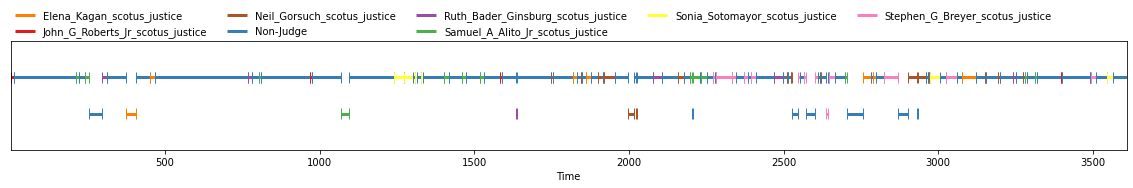

In [ ]:
#load in case we diarized above
os.chdir('/content/drive/MyDrive/1006: Term Project')
case_name = '17-1268'
case17inRTTM_predict = '17-1268_predict.rttm'
predictions = load_rttm(case17inRTTM_predict)[case_name]
predictions

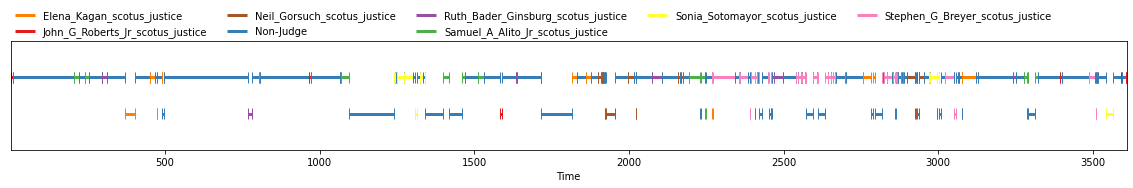

In [ ]:
#load in groundtruths for case
os.chdir('/content/drive/MyDrive/1006: Term Project')
case17inRTTM_w_nonjudge = '171268labels_w_nonjudge.rttm'
groundtruths = load_rttm(case17inRTTM_w_nonjudge)[case_name]
groundtruths

In [ ]:
metric = DiarizationErrorRate(collar=.3, skip_overlap=True)
metric(groundtruths, predictions, detailed=True)

/usr/local/lib/python3.6/dist-packages/pyannote/metrics/utils.py:184: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  "'uem' was approximated by the union of 'reference' "


{'confusion': 260.0799999999689,
 'correct': 3276.5699999999624,
 'diarization error rate': 0.07394632982391898,
 'false alarm': 0.9699999999993452,
 'missed detection': 0.51,
 'total': 3537.1599999999316}

In [ ]:
report = metric.report(display=True)

        diarization error rate   total correct correct false alarm false alarm missed detection missed detection confusion confusion
                             %                       %                       %                                 %                   %
item                                                                                                                                
17-1268                   7.39 3537.16 3276.57   92.63        0.97        0.03             0.51             0.01    260.08      7.35
TOTAL                     7.39 3537.16 3276.57   92.63        0.97        0.03             0.51             0.01    260.08      7.35


In [ ]:
rec = SegmentationRecall(tolerance=.5)
rec(groundtruths, predictions, detailed=True)

{'number of boundaries': 241,
 'number of matches': 28.0,
 'segmentation recall': 0.11618257261410789}

In [ ]:
prec = SegmentationPrecision(tolerance=.5)
prec(groundtruths, predictions, detailed=True)

{'number of boundaries': 130,
 'number of matches': 28.0,
 'segmentation precision': 0.2153846153846154}

In [ ]:
cov = SegmentationCoverage()
cov(groundtruths, predictions, detailed=True)

{'intersection duration': 3239.709999999982,
 'segmentation coverage': 0.8979389901162453,
 'total duration': 3607.9399999999728}

In [ ]:
pur = SegmentationPurity()
pur(groundtruths, predictions, detailed=True)

{'intersection duration': 3140.3099999999886,
 'segmentation purity': 0.870388642826658,
 'total duration': 3607.9399999999728}

In [ ]:
fsc = SegmentationPurityCoverageFMeasure()
fsc(groundtruths, predictions, detailed=True)

{'cvg intersection duration': 3239.709999999982,
 'cvg total duration': 3607.9399999999728,
 'pty intersection duration': 3140.3099999999886,
 'pty total duration': 3607.9399999999728,
 'segmentation F[purity|coverage]': 0.8839492008024894}

# **Diarize (Case 18-280) from speaking times in full audio**

*   labels non-judge speech
*   uses reference audio from Case 17-1268 - > Testing performance using reference speaker embeddings from a different case

## **Diarizing**

In [ ]:
#load case embeddings and time tracking
os.chdir('/content/drive/MyDrive/1006: Term Project')
case_embeds = np.load('18-280_embeds.npy')
embed_times = np.load('18-280_embeds_times.npy')

In [ ]:
#get diarization and set thresh to 0.1 (difference in highest and 2nd highest sim score can't be less than 0.1)
#no speaking segments less than 2 seconds recorded
timelst = diarize(speaker_embs, judge_list, case_embeds, embed_times, thresh = 0.1, small_seg = 2)
timelst

[['John_G_Roberts_Jr_scotus_justice', 0.09, 9.02],
 ['Non-Judge', 9.02, 136.15],
 ['Ruth_Bader_Ginsburg_scotus_justice', 136.15, 162.84],
 ['Non-Judge', 162.84, 212.18],
 ['Ruth_Bader_Ginsburg_scotus_justice', 212.18, 223.68],
 ['Non-Judge', 223.68, 261.78],
 ['Sonia_Sotomayor_scotus_justice', 261.78, 272.82],
 ['Non-Judge', 272.82, 294.64],
 ['Sonia_Sotomayor_scotus_justice', 294.64, 307.46],
 ['Non-Judge', 307.46, 313.71],
 ['Sonia_Sotomayor_scotus_justice', 313.71, 328.6],
 ['Non-Judge', 328.6, 333.81],
 ['Sonia_Sotomayor_scotus_justice', 333.81, 351.38],
 ['Non-Judge', 351.38, 374.64],
 ['Sonia_Sotomayor_scotus_justice', 374.64, 390.09],
 ['Non-Judge', 390.09, 488.15],
 ['Sonia_Sotomayor_scotus_justice', 488.15, 505.44],
 ['Non-Judge', 505.44, 512.93],
 ['Sonia_Sotomayor_scotus_justice', 512.93, 526.88],
 ['Non-Judge', 526.88, 535.48],
 ['Sonia_Sotomayor_scotus_justice', 535.48, 553.09],
 ['Non-Judge', 553.09, 581.29],
 ['Sonia_Sotomayor_scotus_justice', 581.29, 592.67],
 ['Non-Jud

In [ ]:
#generate rttm file for predicted diarization
os.chdir('/content/drive/MyDrive/1006: Term Project')

torttm = []
for i, event in enumerate(timelst):
  torttm.append(' '.join(['SPEAKER 18-280 1', str(event[1]), str(round(event[2]-event[1], 2)), '<NA> <NA>', event[0],'<NA> <NA>']))

w_path = Path(os.getcwd()+'/'+'18-280_predict.rttm')

with open(w_path, 'w') as filehandle:
    for listitem in torttm:
        filehandle.write('%s\n' % listitem)

## **Evaluation**

In [ ]:
'18-280'.replace('-','')

'18280'

In [ ]:
#write groundtruths rttm file to label lawyers as non-judges
# ex: case_docket = '18-280'
def createRTTM(case_docket):
  
  os.chdir('/content/drive/MyDrive/1006: Term Project/data')
  path = os.getcwd()+'/'+'{}.txt'.format(case_docket)
  txt_path = Path(path)

  timelst = []
  f = open(txt_path,'r')
  k = f.readlines()
  f.close()
  for u in k:
    t0, t1, spkr = u.split(' ')[0:3]       
    timelst.append((float(t0),float(t1),spkr))


  torttm = []
  for i, event in enumerate(timelst):
    if 'scotus_justice' in event[2]:
      torttm.append(' '.join(['SPEAKER {} 1'.format(case_docket), str(event[0]), str(round(event[1]-event[0], 2)), '<NA> <NA>', event[2],'<NA> <NA>']))
    else:
      torttm.append(' '.join(['SPEAKER {} 1'.format(case_docket), str(event[0]), str(round(event[1]-event[0], 2)), '<NA> <NA>', 'Non-Judge','<NA> <NA>']))

  with open('/content/drive/MyDrive/1006: Term Project/data/RTTMS/{}labels_w_nonjudge.rttm'.format(case_docket.replace('-','')), 'w') as filehandle:
      for listitem in torttm:
          filehandle.write('%s\n' % listitem)

In [ ]:
createRTTM(case_docket = '18-540')


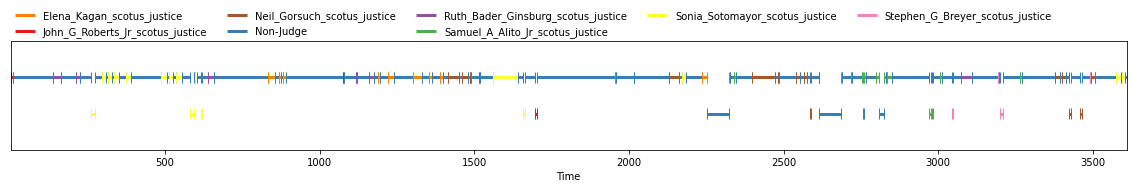

In [ ]:
#load in case we diarized above
os.chdir('/content/drive/MyDrive/1006: Term Project')
case_name = '18-280'
case18inRTTM_predict = '18-280_predict.rttm'
predictions = load_rttm(case18inRTTM_predict)[case_name]
predictions

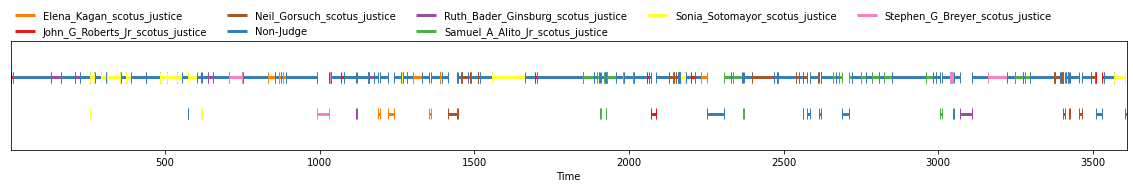

In [ ]:
#load in groundtruths for case
os.chdir('/content/drive/MyDrive/1006: Term Project')
case18inRTTM_w_nonjudge = '18280labels_w_nonjudge.rttm'
groundtruths = load_rttm(case18inRTTM_w_nonjudge)[case_name]
groundtruths

In [ ]:
metric = DiarizationErrorRate(collar=.3, skip_overlap=True)
metric(groundtruths, predictions, detailed=True)

/usr/local/lib/python3.6/dist-packages/pyannote/metrics/utils.py:184: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  "'uem' was approximated by the union of 'reference' "


{'confusion': 572.9799999999731,
 'correct': 3097.0599999999686,
 'diarization error rate': 0.15635524408452814,
 'false alarm': 0.8499999999994543,
 'missed detection': 0.0,
 'total': 3670.0399999999418}

In [ ]:
report = metric.report(display=True)

       diarization error rate   total correct correct false alarm false alarm missed detection missed detection confusion confusion
                            %                       %                       %                                 %                   %
item                                                                                                                               
18-280                  15.64 3670.04 3097.06   84.39        0.85        0.02             0.00             0.00    572.98     15.61
TOTAL                   15.64 3670.04 3097.06   84.39        0.85        0.02             0.00             0.00    572.98     15.61


In [ ]:
rec = SegmentationRecall(tolerance=.5)
rec(groundtruths, predictions, detailed=True)

{'number of boundaries': 247,
 'number of matches': 37.0,
 'segmentation recall': 0.14979757085020243}

In [ ]:
prec = SegmentationPrecision(tolerance=.5)
prec(groundtruths, predictions, detailed=True)

{'number of boundaries': 142,
 'number of matches': 37.0,
 'segmentation precision': 0.2605633802816901}

In [ ]:
cov = SegmentationCoverage()
cov(groundtruths, predictions, detailed=True)

{'intersection duration': 3419.139999999987,
 'segmentation coverage': 0.9135075490198729,
 'total duration': 3742.8699999999735}

In [ ]:
pur = SegmentationPurity()
pur(groundtruths, predictions, detailed=True)

{'intersection duration': 2823.9699999999875,
 'segmentation purity': 0.7544932097561516,
 'total duration': 3742.869999999974}

In [ ]:
fsc = SegmentationPurityCoverageFMeasure()
fsc(groundtruths, predictions, detailed=True)

{'cvg intersection duration': 3419.139999999987,
 'cvg total duration': 3742.8699999999735,
 'pty intersection duration': 2823.9699999999875,
 'pty total duration': 3742.8699999999735,
 'segmentation F[purity|coverage]': 0.8264207784920173}

# Diarize Case from speaking times in multiple cases

In [ ]:
import random

def get_speaker_embs(norm_method = 'average', nonjudge_labels = False ):
  
  random.seed(2021)

  os.chdir('/content/drive/MyDrive/1006: Term Project/data')

  wav_files = list(filter(lambda k: '.wav' in k, os.listdir()))

  speaker_embs_master = {}
  judge_list_master = []

  for wav in wav_files:

    case = wav.strip('.wav')
    print(case)
    # wav_fpath = Path(os.getcwd() + '/{}'.format(wav))
    if nonjudge_labels: 
      rttm_fpath = os.getcwd() + '/RTTMS/w_nonjudge/{}labels_w_nonjudge.rttm'.format(case.replace('-',''))
    else:
      rttm_fpath = os.getcwd() + '/RTTMS/wo_nonjudge/{}labels.rttm'.format(case.replace('-',''))
    
    case_diary = getDiary(rttm_fpath)
    case_diary_shuffle = case_diary
    random.shuffle(case_diary_shuffle)

    case_embeds = np.load('embeds/{}_embeds.npy'.format(case))
    embed_times = np.load('embeds/{}_embeds_times.npy'.format(case))

    speaker_embs, judge_list = ref_speaker_embed(case_diary_shuffle, 5, case_embeds, embed_times, norm_method)

    for k,v in speaker_embs.items():
      if k in speaker_embs_master:
        for i in v:
          speaker_embs_master[k].append(i)
      else:
        speaker_embs_master[k] = v
    
    for judge in judge_list:
      if judge not in judge_list_master:
        judge_list_master.append(judge)

  return speaker_embs_master, judge_list_master

In [ ]:
speaker_embs_master, judge_list_master = get_speaker_embs(norm_method = 'average')

17-1268
17-834


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


18-1233
18-540
18-882
19-161
19-309
19-518
18-280


In [ ]:
# #stupid spaghetti code to fix dict
# for k,v in speaker_embs_master.items():
#   v_new = []
#   for i in v:
#     if len(i) != 256:
#       print('had to fix')
#       for j in i:
#         v_new.append(j)
#     else:
#       print('didnt have to fix')
#       v_new.append(i)
#   speaker_embs_master[k] = v_new

In [ ]:
# #see how many embedding each speaker has 
# for k,v in speaker_embs_master.items():
#   print(len(v))

In [ ]:
#references accross multiple cases

def get_speaker_embs_sample(speaker_embs_master, refs):
  
  speaker_embs_final = {}
  for k,v in speaker_embs_master.items():
    if len(v) < refs:
      speaker_embs_final[k] = v
    else:
      speaker_embs_final[k] = random.sample(v,refs)

  return speaker_embs_final

In [ ]:
speaker_embs_final = get_speaker_embs_sample(speaker_embs_master, refs = 5)

In [ ]:
#generate rttm file for predicted diarization

def createRTTM_predicted(timelst, case_docket):

  os.chdir('/content/drive/MyDrive/1006: Term Project')

  torttm = []
  for i, event in enumerate(timelst):
    torttm.append(' '.join(['SPEAKER {} 1'.format(case_docket), str(event[1]), str(round(event[2]-event[1], 2)), '<NA> <NA>', event[0],'<NA> <NA>']))

  w_path = Path(os.getcwd()+'/data/RTTMS/predicted/{}_predict.rttm'.format(case_docket))

  with open(w_path, 'w') as filehandle:
      for listitem in torttm:
          filehandle.write('%s\n' % listitem)

In [ ]:
#load case embeddings and time tracking

def test_references(speaker_embs_final, judge_list_master, case):

  os.chdir('/content/drive/MyDrive/1006: Term Project')
  
  case_embeds = np.load('data/embeds/{}_embeds.npy'.format(case))
  embed_times = np.load('data/embeds/{}_embeds_times.npy'.format(case))

  #get diarization and set thresh to 0.1 (difference in highest and 2nd highest sim score can't be less than 0.1)
  #no speaking segments less than 2 seconds recorded
  timelst = diarize(speaker_embs_final, judge_list_master, case_embeds, embed_times, thresh = 0.1, small_seg = 2)

  createRTTM_predicted(timelst, case_docket = case)

  RTTM_predicted = os.getcwd()+'/data/RTTMS/predicted/{}_predict.rttm'.format(case)
  predictions = load_rttm(RTTM_predicted)[case]

  RTTM_w_nonjudge = os.getcwd()+'/data/RTTMS/w_nonjudge/{}labels_w_nonjudge.rttm'.format(case.replace('-',''))
  # print(RTTM_w_nonjudge)
  groundtruths = load_rttm(RTTM_w_nonjudge)[case]

  metric = DiarizationErrorRate(collar=.3, skip_overlap=True)
  metric_dict = metric(groundtruths, predictions, detailed=True)

  return predictions, groundtruths, metric_dict

In [ ]:
predictions, groundtruths, metrics = test_references(speaker_embs_final, judge_list_master, case = '18-280')
metrics

/usr/local/lib/python3.6/dist-packages/pyannote/metrics/utils.py:184: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  "'uem' was approximated by the union of 'reference' "


{'confusion': 569.8999999999763,
 'correct': 3100.1399999999694,
 'diarization error rate': 0.15551601617420632,
 'false alarm': 0.8499999999994543,
 'missed detection': 0.0,
 'total': 3670.039999999946}

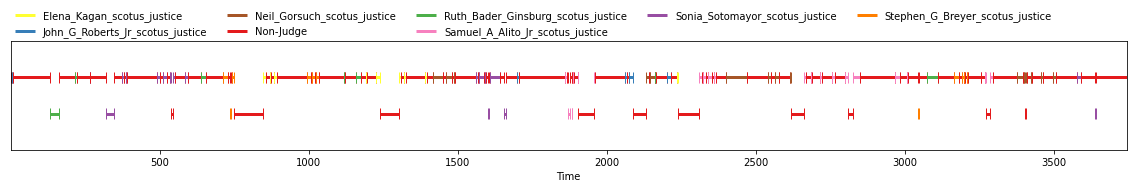

In [ ]:
predictions

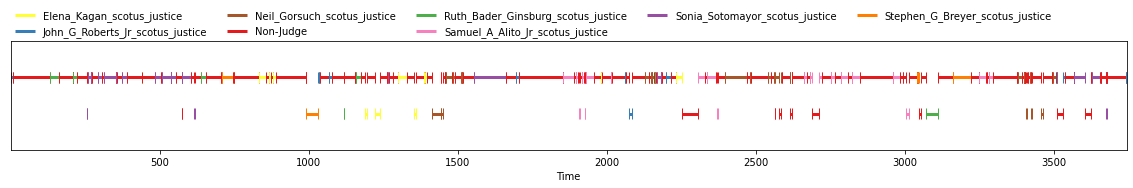

In [ ]:
groundtruths

In [ ]:
predictions, groundtruths, metrics = test_references(speaker_embs_final, judge_list_master, case = '17-1268')
metrics

/usr/local/lib/python3.6/dist-packages/pyannote/metrics/utils.py:184: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  "'uem' was approximated by the union of 'reference' "


{'confusion': 581.6099999999695,
 'correct': 2955.039999999962,
 'diarization error rate': 0.16484693935246936,
 'false alarm': 0.9699999999997999,
 'missed detection': 0.51,
 'total': 3537.159999999932}

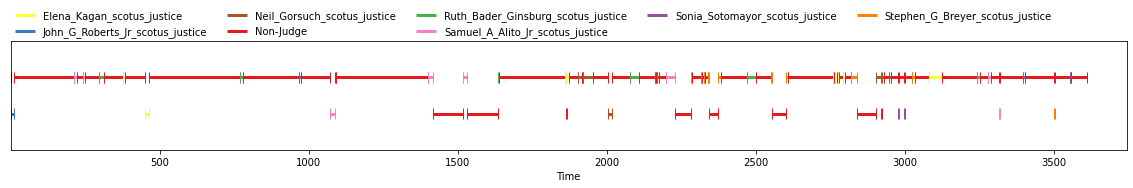

In [ ]:
predictions

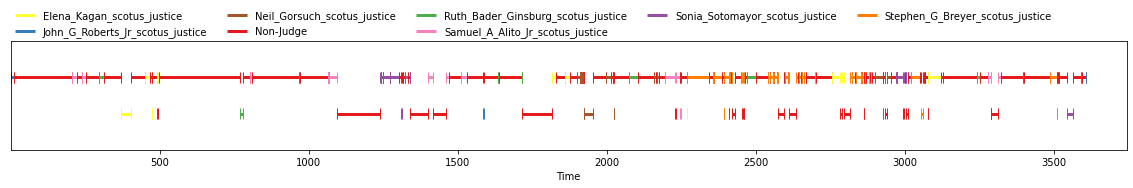

In [ ]:
groundtruths

In [ ]:
os.chdir('/content/drive/MyDrive/1006: Term Project/data')

wav_files = list(filter(lambda k: '.wav' in k, os.listdir()))

avg_error = 0

for wav in wav_files:

  case = wav.strip('.wav')

  predictions, groundtruths, metrics = test_references(speaker_embs_final, judge_list_master, case = case)
  error = metrics['diarization error rate']
  avg_error += error

print('average error accross all cases:', avg_error/len(wav_files))

/usr/local/lib/python3.6/dist-packages/pyannote/metrics/utils.py:184: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  "'uem' was approximated by the union of 'reference' "


average error accross all cases: 0.2425510525904648


# Cluster Testing

In [ ]:
speaker_embs_master, judge_list_master = get_speaker_embs(norm_method = 'cluster')

17-1268
17-834
cluster did not work


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


18-1233
18-540
18-882
19-161
19-309
19-518
18-280


In [ ]:
speaker_embs_final = get_speaker_embs_sample(speaker_embs_master, refs = 10)

In [ ]:
#clean up dimension
speaker_embs_final2 = {}
for k,v in speaker_embs_final.items():
  new_v = []
  for i in v:
    # print(type(i[0]))
    # if isinstance(i[0],list) is True:
      # print('True')
    new_v.append(i[0])

  speaker_embs_final2[k] = new_v



In [ ]:
#clean up nan? not sure why there is a nan will have to look into 
speaker_embs_final3 = {}
for k,v in speaker_embs_final2.items():
  speaker_embs_final3[k] = []
  for i in v:
    try:
      length = (len(i))
      speaker_embs_final3[k].append(i)
    except:
      print(i, type(i))

nan <class 'numpy.float32'>


In [ ]:
predictions, groundtruths, metrics = test_references(speaker_embs_final3, judge_list_master, case = '18-280')
metrics

/usr/local/lib/python3.6/dist-packages/pyannote/metrics/utils.py:184: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  "'uem' was approximated by the union of 'reference' "


{'confusion': 764.179999999974,
 'correct': 2905.8599999999733,
 'diarization error rate': 0.20845276890714678,
 'false alarm': 0.849999999999909,
 'missed detection': 0.0,
 'total': 3670.0399999999468}

In [ ]:
predictions, groundtruths, metrics = test_references(speaker_embs_final3, judge_list_master, case = '17-1268')
metrics

/usr/local/lib/python3.6/dist-packages/pyannote/metrics/utils.py:184: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  "'uem' was approximated by the union of 'reference' "


{'confusion': 653.2199999999691,
 'correct': 2883.4299999999653,
 'diarization error rate': 0.18509199470761317,
 'false alarm': 0.9699999999997999,
 'missed detection': 0.51,
 'total': 3537.1599999999344}

In [ ]:
os.chdir('/content/drive/MyDrive/1006: Term Project/data')

wav_files = list(filter(lambda k: '.wav' in k, os.listdir()))

avg_error = 0

for wav in wav_files:

  case = wav.strip('.wav')

  predictions, groundtruths, metrics = test_references(speaker_embs_final3, judge_list_master, case = case)
  error = metrics['diarization error rate']
  avg_error += error

print('average error accross all cases:', avg_error/len(wav_files))

/usr/local/lib/python3.6/dist-packages/pyannote/metrics/utils.py:184: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  "'uem' was approximated by the union of 'reference' "


average error accross all cases: 0.26632076012598654
